In [55]:
import pydicom
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime
from IPython.display import clear_output


In [2]:
# Parameters for Cube Geometry
cube_half_width = 75 # mm
cube_inside_bevel = 67 # mm
bevel_radius = cube_half_width - cube_inside_bevel
cube_HU = -15

sphere_diameter = 7.5 # mm
sphere_centers = np.array([[-10,-25,-30],[10,-15,-15],[0,0,0],[-20,20,10],[20,30,20]])
sphere_HU = 3060

# Parameters to jitter cube surface to make it imperfect
include_jitter = False
max_jitter = 0.02 # mm

# Parameters for Image Geometry
image_matrix_size = 256
image_physical_size = 200 # mm
image_pixel_size = image_physical_size / image_matrix_size
image_positions = np.arange(image_matrix_size)*image_pixel_size + image_pixel_size/2 - image_physical_size/2


# Parameters for Slice Geometry
number_of_slices = 256
image_physical_length = 200 # mm
slice_width = image_physical_length / number_of_slices # plus one?
slice_positions = np.arange(number_of_slices)*slice_width + slice_width/2 - image_physical_length/2

In [3]:
def is_in_sphere(loc):
    """Checks whether the point loc is in the cube
    
    PARAMETERS
    ----------
    loc : list of float
        A list of length 3 corresponding to the x, y and z coordinates of the point
    
    RETURNS
    -------
    True if the point is in the a sphere, else False
    
    """
    
    assert len(loc) == 3, "loc must be a list of three floating point integers"
    
    for origin in sphere_centers:
        vec = loc - origin
        dist = np.linalg.norm(vec)
        if dist <= sphere_diameter/2:
            return True
    
    return False

def is_in_cube(loc, rounded_edges=True):
    """Checks whether the point loc is in the cube
    
    PARAMETERS
    ----------
    loc : list of float
        A list of length 3 corresponding to the x, y and z coordinates of the point
    rounded_edges: bool
        If True, evaluates for a cube with rounded edges. If false, assumes cube
        has sharp edges (default is True)
    
    RETURNS
    -------
    True if the point is in the cube, else False
    
    """
    
    assert len(loc) == 3, "loc must be a list of three floating point integers"
    
    # Cube is symmetric, take abs of x,y,z, convert to ndarray which allows slicing
    loc = np.abs(loc)
    
    # Case 1: Any of the values are greater than the cube half-width, return false:
    if any(loc > cube_half_width):
        return False
    
    # If we are not using rounded edges, then we are done. Return True
    if not rounded_edges:
        return True
    
    # Case 2: All of the values are less than the cube_inside_bevel, return True:
    if all(loc <= cube_inside_bevel):
        return True
    
    # Case 3: If exactly one dimension is greater than cube_inside_bevel, 
    # then the point is adjacent to a cube face, return True:
    if sum(loc > cube_inside_bevel) == 1:
        return True

    # Case 4: If exactly two dimensions are greater than cube_inside_bevel, 
    # then the point is adjacent to a cube edge. The point defined by the two
    # dimensions that are greater than the cube_inside_bevel must be within a 
    # radius of bevel_radius of the point cube_inside_bevel*[1,1]:
    if sum(loc > cube_inside_bevel) == 2:
        
        # Get the indicies whose value is greater than cube_inside_bevel
        tf_array = loc > cube_inside_bevel
    
        # Create a 2D vector from the origin to the point in the edge region
        origin = cube_inside_bevel*np.ones((3,1))
        
        vec = loc[tf_array] - origin[tf_array]
        dist = np.linalg.norm(vec)
        if dist <= bevel_radius:
            return True
        else:
            return False
    
    # Case 5: If exactly three dimensions are greater than cube_inside_bevel, 
    # then the point is adjacent to a cube corner. The point must be within a 
    # radius of bevel_radius of the point cube_inside_bevel*[1,1,1]:
    if sum(loc > cube_inside_bevel) == 3:
        origin = cube_inside_bevel*np.ones((3,1))
        vec = loc - origin
        dist = np.linalg.norm(vec)
        if dist <= bevel_radius:
            return True
        else:
            return False
    
    



In [4]:
def is_in_sphere_np(x, y, z):
    """
    
    PARAMETERS
    ----------
    x : list of float
        A list of image coordinates in the x-dimension
    y : list of float
        A list of image coordinates in the y-dimension
    z : list of float
        A list of image coordinates in the z-dimension
    
    RETURNS
    -------
    A 3D array of shape (len(x),len(y),len(z)), where the array value (i,j,k) is True 
    if the point x[i], y[j], z[k] is locted in a in the a sphere, else False
    
    """
        
    XX, YY, ZZ = np.meshgrid(x, y, z, indexing='ij')
    
    is_in_sphere_array = np.zeros(XX.shape, dtype=bool)
    
    for origin in sphere_centers:
        DXX = XX - origin[0]
        DYY = YY - origin[1]
        DZZ = ZZ - origin[2]
        
        quad_sum = np.square(DXX) + np.square(DYY) + np.square(DZZ)
        
        is_in_this_sphere = (quad_sum <= (sphere_diameter/2)**2)
        
        np.logical_or(is_in_this_sphere, is_in_sphere_array, out=is_in_sphere_array)
    
    return is_in_sphere_array

In [5]:
# Building a metadata writer

def write_meta_data(dcm):

    # Instance creation
    now = datetime.datetime.now()
    now_date = now.strftime("%Y%m%d")
    now_time = now.strftime("%H%M%S")

    # Dates
    dcm.InstanceCreationDate = now_date
    dcm.StudyDate = now_date
    dcm.SeriesDate = now_date
    dcm.ContentDate = now_date

    # Times
    dcm.InstanceCreationTime = now_time
    dcm.StudyTime = now_time
    dcm.SeriesTime = now_time
    dcm.ContentTime = now_time

    # Description
    dcm.StudyDescription = "Virtual AlignRT Cube"
    dcm.SeriesDescription = f"Matrix size: {image_matrix_size}, Image size: {image_physical_size} mm"
    dcm.OperatorsName = "djj379"

    # Patient information
    dcm.PatientName = "ZZUWQA^AlignRTCube"
    dcm.PatientID = "20210101DJJ"
    dcm.PatientBirthDate = now_date
    dcm.PatientBirthTime = now_time

    return dcm

def write_image_dimensions(dcm, slice_index, slice_width, slice_positions, image_positions, image_matrix_size, image_pixel_size):
    
    # Image Dimensions
    dcm.SliceThickness = slice_width
    dcm.ImagePositionPatient = [image_positions[0], image_positions[0], slice_positions[0]]
    dcm.SliceLocation = slice_positions[slice_index]
    dcm.Rows = image_matrix_size
    dcm.Columns = image_matrix_size
    dcm.PixelSpacing = [image_pixel_size, image_pixel_size]
    
    
    
    

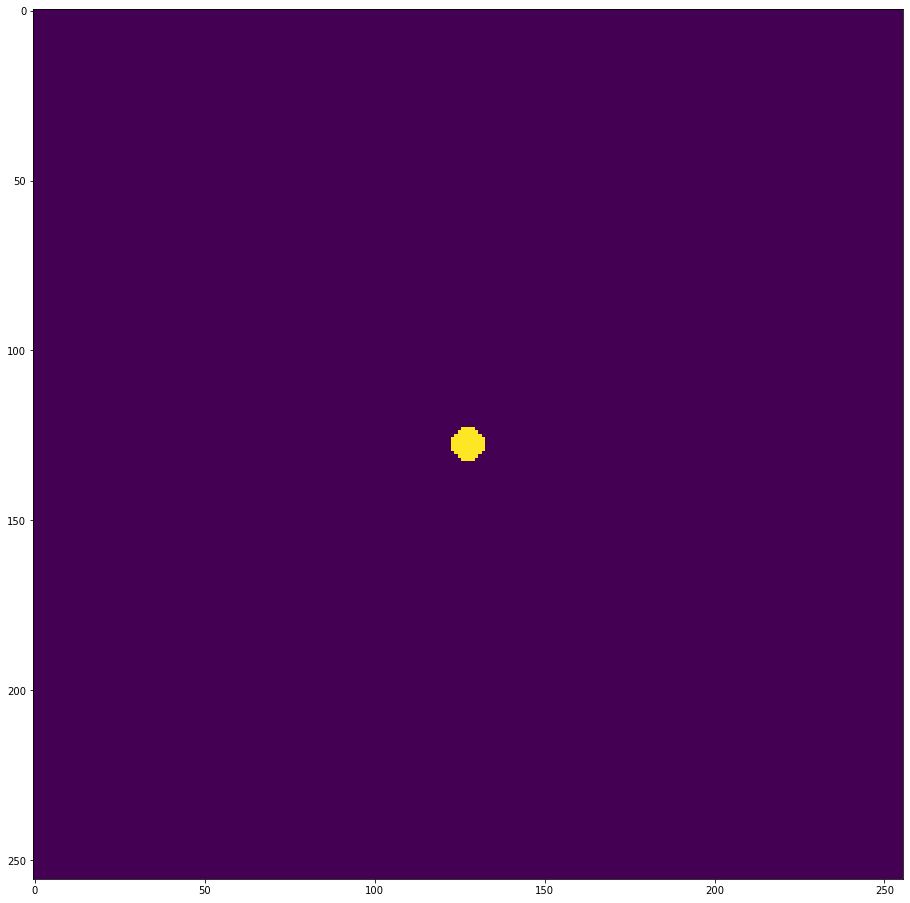

In [6]:
# Create 3D data matrix

pixel_map = np.zeros((image_matrix_size, image_matrix_size, number_of_slices))-1000

tf_in_sphere = is_in_sphere_np(image_positions, image_positions, slice_positions)

pixel_map[tf_in_sphere] = sphere_HU

img_shape = list(pixel_map.shape)

img3d = pixel_map


# plot 3 orthogonal slices
f, axs = plt.subplots(1,1,figsize=(16,16))

plt.imshow(img3d[img_shape[0]//2,:,:])
plt.imshow(img3d[:, img_shape[1]//2, :])
plt.imshow(img3d[:, :, img_shape[2]//2])

# plt.show()



In [51]:
dicom_path = Path("../visionrt-cube-dicom/data/")
save_path = Path("output/")

# load the DICOM files
files = []

for fname in dicom_path.iterdir():
    # print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))


print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:

    if hasattr(f, 'SliceLocation'):
        slices.append(f)       
    else:
        skipcount = skipcount + 1
        
    

print("skipped, no SliceLocation: {}".format(skipcount))



256
skipped, no SliceLocation: 2


In [12]:
for f in files:
    print(f.pixel_array)

[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]
[0.2, 0.2]

AttributeError: 'FileDataset' object has no attribute 'PixelSpacing'

In [13]:
for i, image in enumerate(slices):
    file_name = f"{image.Modality}.{i}.dcm"
    
    image = write_meta_data(image)
    
    # Image Dimensions
    #image.SliceThickness = slice_width
    #image.ImagePositionPatient = [image_positions[0], image_positions[0], slice_positions[i]]
    #image.SliceLocation = slice_positions[i]
    #image.Rows = image_matrix_size
    #image.Columns = image_matrix_size
    #image.PixelSpacing = [image_pixel_size, image_pixel_size]
    
    image.PixelData = pixel_map[:,:,i].reshape((image_matrix_size, image_matrix_size)).tobytes()
    
    image.save_as(save_path / file_name)
 

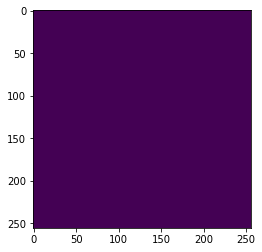

In [20]:
plt.imshow(pixel_map[:,:,i].reshape((image_matrix_size, image_matrix_size)))

-25.5
-23.7
-5.7
-5.5
-5.3
-5.1
-4.9
-4.7
-4.5
-4.3
-4.1
-3.9
-23.5
-3.7
-3.5
-3.3
-3.1
-2.9
-2.7
-2.5
-2.3
-2.1
-1.9
-23.3
-1.7
-1.5
-1.3
-1.1
-0.9
-0.7
-0.5
-0.3
-0.1
0.1
-23.1
0.3
0.5
0.7
0.9
1.1
1.3
1.5
1.7
1.9
2.1
-22.9
2.3
2.5
2.7
2.9
3.1
3.3
3.5
3.7
3.9
4.1
-22.7
4.3
4.5
4.7
4.9
5.1
5.3
5.5
5.7
5.9
6.1
-22.5
6.3
6.5
6.7
6.9
7.1
7.3
7.5
7.7
7.9
8.1
-22.3
8.3
8.5
8.7
8.9
9.1
9.3
9.5
9.7
9.9
10.1
-22.1
10.3
10.5
10.7
10.9
11.1
11.3
11.5
11.7
11.9
12.1
-21.9
12.3
12.5
12.7
12.9
13.1
13.3
13.5
13.7
13.9
14.1
-25.3
-21.7
14.3
14.5
14.7
14.9
15.1
15.3
15.5
15.7
15.9
16.1
-21.5
16.3
16.5
16.7
16.9
17.1
17.3
17.5
17.7
17.9
18.1
-21.3
18.3
18.5
18.7
18.9
19.1
19.3
19.5
19.7
19.9
20.1
-21.1
20.3
20.5
20.7
20.9
21.1
21.3
21.5
21.7
21.9
22.1
-20.9
22.3
22.5
22.7
22.9
23.1
23.3
23.5
23.7
23.9
24.1
-20.7
24.3
24.5
24.7
24.9
25.1
25.3
25.5
-20.5
-20.3
-20.1
-19.9
-25.1
-19.7
-19.5
-19.3
-19.1
-18.9
-18.7
-18.5
-18.3
-18.1
-17.9
-24.9
-17.7
-17.5
-17.3
-17.1
-16.9
-16.7
-16.5
-16.3
-16.1
-15.9
-

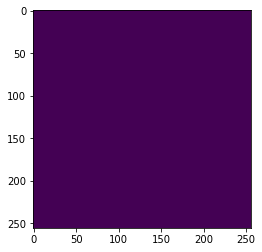

In [33]:
from time import sleep
for s in slices:
    print(s.SliceLocation)
    plt.imshow(s.pixel_array)
    sleep(0.01)
    

In [32]:
s.PatientName

'ZZUWQA^AlignRTCube'

TypeError: 'AxesImage' object is not iterable

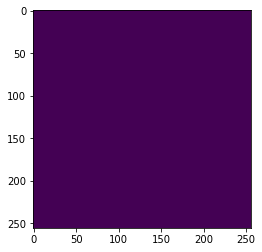

In [57]:
fig = plt.figure()

def updatefig(*args):
    


slices = sorted(slices, key=lambda s:s.SliceLocation)
ims = list()
for s in slices:

    im = plt.imshow(s.pixel_array, animated=True)
    ims.append(im)

ani= animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

plt.show()


In [59]:
type(ims

NameError: name 'ims0' is not defined